In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

First, remove artefacts, center and smoothen the raw GROMACS trajectories using the `trjconv` module.

```bash
gmx trjconv -s md500.tpr -f md500.xtc -n index.ndx -o md500_compact.xtc -center -pbc mol -ur compact
gmx trjconv -s md500.tpr -f md500_compact.xtc -n index.ndx -o md500_compact_compact.xtc -fit rot+trans
```

Dump out the first frame of the trajectory

```bash
gmx trjconv -s md500.tpr -f md500_compact.xtc -n index.ndx -o md500_start.pdb -dump 0
```

In all cases, Choose `Protein` for centering and `Protein_LIG_ZN2` for output. Not selecting the whole system for output removes water and loose ions and compresses the trajectory files.



## RMSD Calculation

In [2]:
#Read all the trajectories
mmp9_sb3ct_01 = mda.Universe('/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run1/md500_start.pdb', '/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run1/md500_compact_compact.xtc')
mmp9_sb3ct_02 = mda.Universe('/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run2/md500_start.pdb', '/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run2/md500_compact_compact.xtc')

In [5]:
from MDAnalysis.analysis import rms

R = rms.RMSD(mmp9_sb3ct_01,  # universe to align
    mmp9_sb3ct_01,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c_run1 = R.results.rmsd[:,1]
rmsd_c_run1 = R.results.rmsd[:,2]

  0%|          | 0/50001 [00:00<?, ?it/s]

In [6]:
from MDAnalysis.analysis import rms

R = rms.RMSD(mmp9_sb3ct_02,  # universe to align
    mmp9_sb3ct_02,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c_run2 = R.results.rmsd[:,1]
rmsd_c_run2 = R.results.rmsd[:,2]   

  0%|          | 0/50001 [00:00<?, ?it/s]

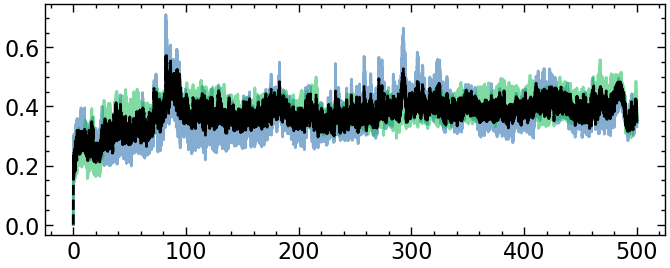

In [12]:
plt.plot(times_c_run1/1000, rmsd_c_run1/10, alpha=0.5)
plt.plot(times_c_run2/1000, rmsd_c_run2/10, alpha=0.5)

times_c = (times_c_run1 + times_c_run2)/2
rmsd_c = (rmsd_c_run1 + rmsd_c_run2)/2

plt.plot(times_c/1000, rmsd_c/10, 'k--')
fig = plt.gcf()
fig.set_figheight(fig.get_figheight() / 2)


## Radius of Gyration Calculation

In [13]:
from tqdm.notebook import tqdm
group = mmp9_sb3ct_01.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(mmp9_sb3ct_01.trajectory):
	Frame.append(ts.frame)
	times.append(mmp9_sb3ct_01.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_run1_table = np.vstack((Frame, times, Rgyr)).T

100%|██████████| 50001/50001 [01:50<00:00, 454.50it/s]


In [14]:
from tqdm.notebook import tqdm
group = mmp9_sb3ct_02.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(mmp9_sb3ct_02.trajectory):
	Frame.append(ts.frame)
	times.append(mmp9_sb3ct_02.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_run2_table = np.vstack((Frame, times, Rgyr)).T

  0%|          | 0/50001 [00:00<?, ?it/s]

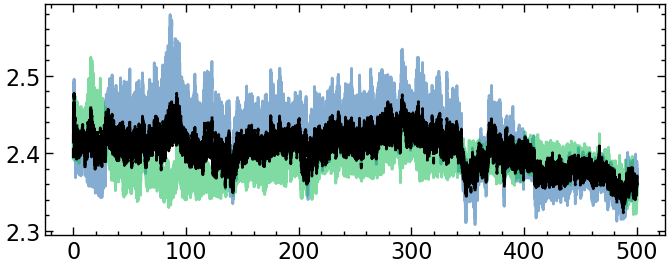

In [16]:
plt.plot(Rgyrc_run1_table[:,1]/1000, Rgyrc_run1_table[:,2]/10, alpha=0.5)
plt.plot(Rgyrc_run2_table[:,1]/1000, Rgyrc_run2_table[:,2]/10, alpha=0.5)

Rgyrc_table = (Rgyrc_run1_table + Rgyrc_run2_table)/2
plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10,'k--')

fig = plt.gcf()
fig.set_figheight(fig.get_figheight() / 2)

## RMSF Calculation

Between protein backbone and Carbon alphas.

In [18]:
c_alphas_c_run1 = mmp9_sb3ct_01.select_atoms('backbone and name CA')
R_c_run1 = rms.RMSF(c_alphas_c_run1).run(verbose=True)

  0%|          | 0/50001 [00:00<?, ?it/s]

In [19]:
c_alphas_c_run2 = mmp9_sb3ct_02.select_atoms('backbone and name CA')
R_c_run2 = rms.RMSF(c_alphas_c_run2).run(verbose=True)

  0%|          | 0/50001 [00:00<?, ?it/s]

In [20]:
c_alphas_c_resids = (c_alphas_c_run1.resids + c_alphas_c_run2.resids)/2
R_c_results_rmsf = (R_c_run1.results.rmsf + R_c_run2.results.rmsf)/2

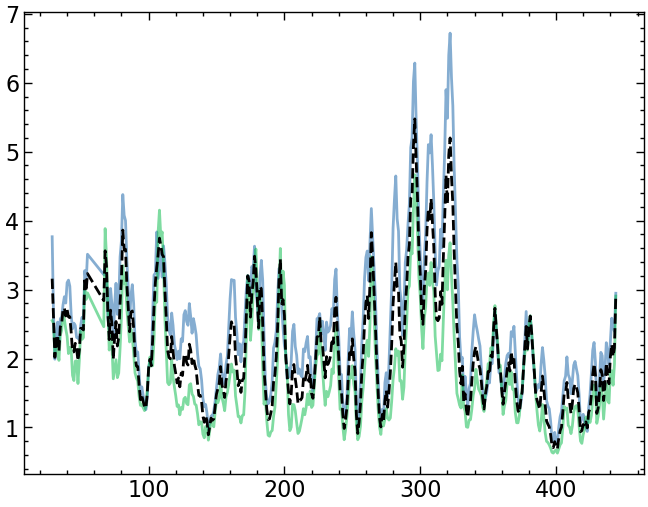

In [21]:
plt.plot(c_alphas_c_run1.resids, R_c_run1.results.rmsf, alpha=0.5)
plt.plot(c_alphas_c_run2.resids, R_c_run2.results.rmsf, alpha=0.5)
plt.plot(c_alphas_c_resids, R_c_results_rmsf, 'k--')

## H-bond analysis:

**Note:** As of today (20241222), the latest version of MDAnalysis (2.8) cannot read binary topology files (the ones with the `.tpr` extension) created by gromacs version 2024.4. Binary topology data is necessary for hydrogen bond analysis in `MDAnalysis` for some reason, so I am trying `MDTraj` instead.


In `MDTraj`, the Baker-Hubbard Hydrogen Bond Identification can be used, where the hydrogen bond is said to have formed if:

1. The angle $\theta_{dha}>2\pi/3$, *i.e.*, $120$ degrees, and
2. The distance $r_{ha}<0.25\;nm$. 
   
Here, $d$ means 'donor', 'h' means 'hydrogen', and 'a' means acceptor.
The donors considered by this method are NH and OH, and the acceptors considered are O and N.

Do not load the whole trajectory, as it will take up too much memory. Unlike `MDAnalysis`, `MDTraj` doesn't do lazy loads from disk, but fully operates in memory. This makes it faster, but memory-intensive.

So, we choose a 'stride' of, say, $60$ frames, and have `MDTraj` load every $60^{th}$ frame of the trajectory, then run the baker-hubbard algorithm.

In [75]:
stride = 60
total_frames = 50000
total_time_ns = 500

timestep  = (stride/total_frames) * total_time_ns

nframes = int(np.ceil(total_frames/stride))

timestep, nframes

(0.6, 834)

In [30]:
%%time
import numpy as np
import mdtraj as md


xtcfile='/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run1/md500_compact_compact.xtc'
topfile='/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run1/md500_start.pdb'

full_traj_run1 = md.load_xtc(xtcfile, stride=stride, top=topfile)
sb3ct_atoms = full_traj_run1.topology.select('resname LIG')
hbonds = md.baker_hubbard(full_traj_run1, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj_run1.topology.atom(hbond[0]),\
                                            full_traj_run1.topology.atom(hbond[1]),\
                                            full_traj_run1.topology.atom(hbond[2]))
sb3ct_hbonds_run1 = []
for hbond in hbonds:
    d,h,a = hbond
    if d in sb3ct_atoms or a in sb3ct_atoms:
        sb3ct_hbonds_run1.append(hbond)
        print(label(hbond))

sb3ct_hbonds_run1 = np.array(sb3ct_hbonds_run1)

ARG424-N - ARG424-H ... LIG502-O
ARG424-N - ARG424-H ... LIG502-O1
CPU times: user 50.4 s, sys: 7.07 s, total: 57.5 s
Wall time: 56.6 s


In [31]:
%%time
import numpy as np
import mdtraj as md


xtcfile='/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run2/md500_compact_compact.xtc'
topfile='/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run2/md500_start.pdb'

full_traj_run2 = md.load_xtc(xtcfile, stride=stride, top=topfile)
sb3ct_atoms = full_traj_run2.topology.select('resname LIG')
hbonds = md.baker_hubbard(full_traj_run2, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj_run2.topology.atom(hbond[0]),\
                                            full_traj_run2.topology.atom(hbond[1]),\
                                            full_traj_run2.topology.atom(hbond[2]))
sb3ct_hbonds_run2 = []
for hbond in hbonds:
    d,h,a = hbond
    if d in sb3ct_atoms or a in sb3ct_atoms:
        sb3ct_hbonds_run2.append(hbond)
        print(label(hbond))

sb3ct_hbonds_run2 = np.array(sb3ct_hbonds_run2)

ARG424-N - ARG424-H ... LIG502-O
ARG424-N - ARG424-H ... LIG502-O1
THR426-OG1 - THR426-HG1 ... LIG502-O
CPU times: user 49.9 s, sys: 3 s, total: 52.9 s
Wall time: 52.2 s


So, according to `MDTraj` Baker-Hubbard hbond detector, there are only $3$ hydrogen bonds that form at more than a frequency of `freq=` $0.01$ in the trajectory frames. In run2, an extra bond is detected, *viz.* `THR426-OG1 - THR426-HG1 ... LIG502-O`


Calculate the distances and angles for each hbond.

In [32]:
da_distances_run1 = md.compute_distances(full_traj_run1, sb3ct_hbonds_run1[:, [1,2]], periodic=False)
da_angles_run1 = md.compute_angles(full_traj_run1, sb3ct_hbonds_run1, periodic=False)

Let us get the number of hbonds between protein and ligand.

In [45]:
distance_met_run1 = da_distances_run1 < 0.25
angle_met_run1 = da_angles_run1 > 2 * np.pi/3
hbond_met_run1 = np.logical_and(distance_met_run1, angle_met_run1)
num_hbonds_run1 = np.sum(hbond_met_run1, axis=1)

In [46]:
da_distances_run2 = md.compute_distances(full_traj_run2, sb3ct_hbonds_run2[:, [1,2]], periodic=False)
da_angles_run2 = md.compute_angles(full_traj_run2, sb3ct_hbonds_run2, periodic=False)

In [47]:
distance_met_run2 = da_distances_run2 < 0.25
angle_met_run2 = da_angles_run2 > 2 * np.pi/3
hbond_met_run2 = np.logical_and(distance_met_run2, angle_met_run2)
num_hbonds_run2 = np.sum(hbond_met_run2, axis=1)

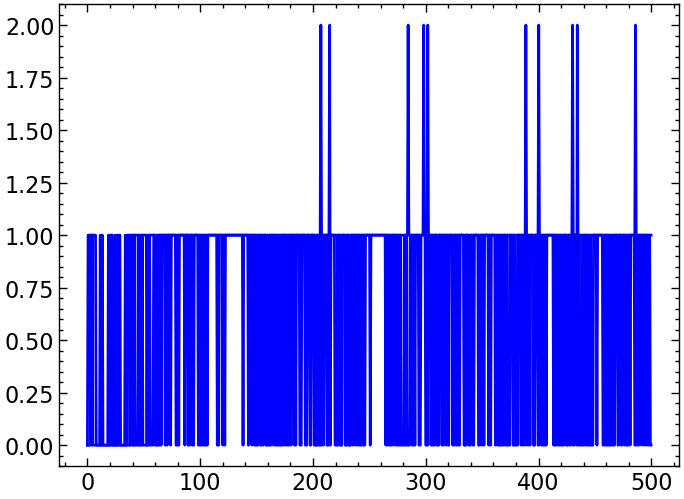

In [64]:
plt.plot(full_traj_run1.time/1000, num_hbonds_run1,'b-')
plt.plot(full_traj_run2.time/1000, num_hbonds_run2,'b-')


## Plots

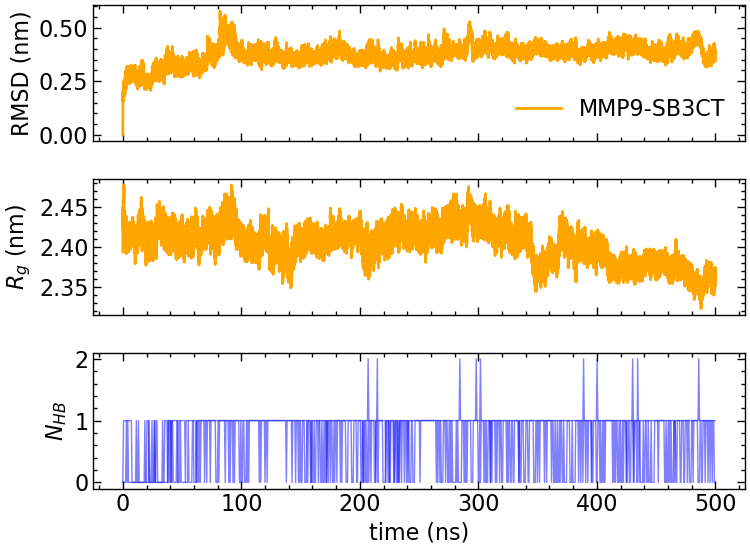

In [77]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True)

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');


ax_rmsd.plot(times_c/1000, rmsd_c/10, label="MMP9-SB3CT", 
        color='orange')

ax_rmsd.legend()

ax_rg = axs[1]

ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="MMP9-SB3CT", color='orange')
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');

ax_bonds.plot(timestep * np.arange(nframes), num_hbonds_run1, lw=1, label="MMP9-SB3CT", alpha=0.5,color='blue')
ax_bonds.plot(timestep * np.arange(nframes), num_hbonds_run2, lw=1, label="MMP9-SB3CT", alpha=0.5,color='blue')


ax_bonds.set_ylabel(r"$N_{HB}$")
#plt.savefig("time-series-plots.png", dpi=600)
plt.show()

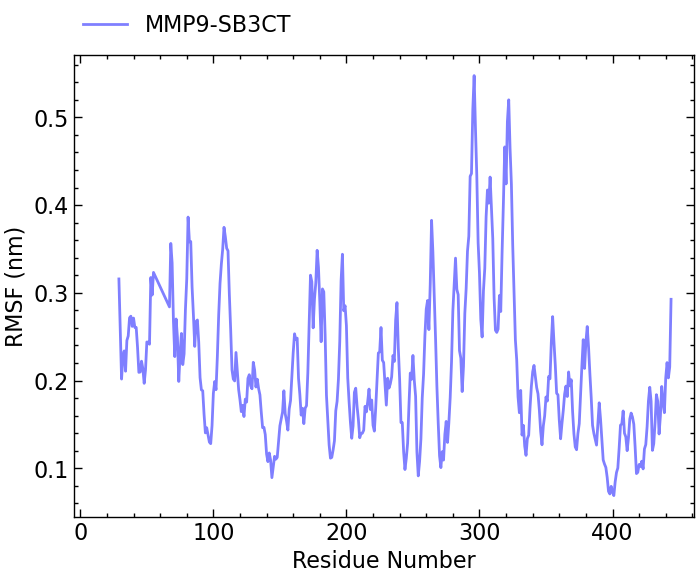

In [78]:
import matplotlib.pyplot as plt

line_c, = plt.plot(c_alphas_c_resids, R_c_results_rmsf/10, label="MMP9-SB3CT", 
                alpha=0.5, color="blue")

plt.xlabel('Residue Number')
plt.ylabel('RMSF (nm)')
plt.xlim(-5, 461)
#ax1.set_ylim(-0.02, 0.45)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=2, mode="expand", borderaxespad=0.);

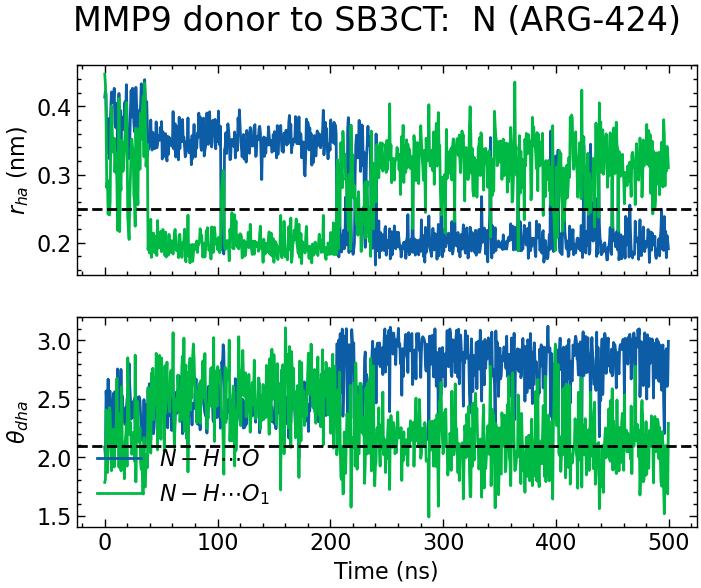

In [90]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
fig.suptitle('MMP9 donor to SB3CT:  N (ARG-424)')
nframes, n_hbonds = da_distances_run1.shape


ax0.plot(timestep * np.arange(nframes), da_distances_run1[:,0], label=r'$N-H\cdots O$')
ax0.plot(timestep * np.arange(nframes), da_distances_run1[:,1], label=r'$N-H\cdots O_1$')

ax0.axhline(0.25, color='black', linestyle='--')
ax0.set_ylabel(r'$r_{ha}$ (nm)')


nframes, n_hbonds = da_angles_run1.shape

ax1.plot(timestep * np.arange(nframes), da_angles_run1[:,0],label=r'$N-H\cdots O$')
ax1.plot(timestep * np.arange(nframes), da_angles_run1[:,1],label=r'$N-H\cdots O_1$')
ax1.axhline(2 * np.pi/3, color='black', linestyle='--')
ax1.set_ylabel(r'$\theta_{dha}$')

ax1.set_xlabel('Time (ns)')
ax1.legend();


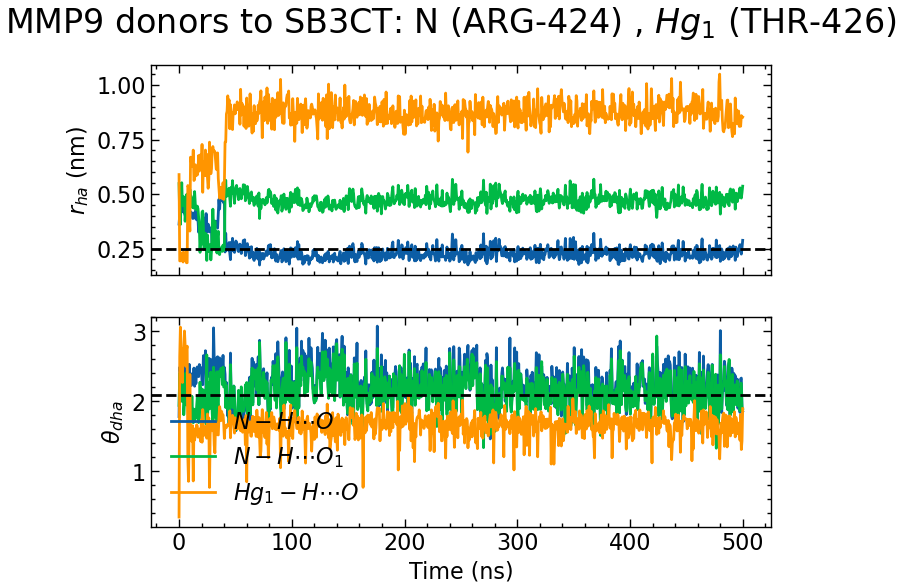

In [94]:
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
fig.suptitle(r'MMP9 donors to SB3CT: N (ARG-424) , $Hg_1$ (THR-426)')


nframes, n_hbonds = da_distances_run2.shape
ax0.plot(timestep * np.arange(nframes), da_distances_run2[:,0], label=r'$N-H\cdots O$')
ax0.plot(timestep * np.arange(nframes), da_distances_run2[:,1], label=r'$N-H\cdots O_1$')
ax0.plot(timestep * np.arange(nframes), da_distances_run2[:,2], label=r'$HG_1-H\cdots O$')
ax0.axhline(0.25, color='black', linestyle='--')
ax0.set_ylabel(r'$r_{ha}$ (nm)')


nframes, n_hbonds = da_angles_run2.shape

ax1.plot(timestep * np.arange(nframes), da_angles_run2[:,0],label=r'$N-H\cdots O$')
ax1.plot(timestep * np.arange(nframes), da_angles_run2[:,1],label=r'$N-H\cdots O_1$')
ax1.plot(timestep * np.arange(nframes), da_angles_run2[:,2], label=r'$Hg_1-H\cdots O$')
ax1.axhline(2 * np.pi/3, color='black', linestyle='--')
ax1.set_ylabel(r'$\theta_{dha}$')

ax1.set_xlabel('Time (ns)')
ax1.legend();


As can be seen from the above analysis, there is basically just one hbond being consistently detected, namely, $N (424-ARG)-H\cdots O$. The other two, namely $N (424-ARG)-H\cdots O_1$ and $HG_1 (426-THR)-H\cdots O$, are intermittent and go away at long times. I think that we can ignore it.

## Principal Component Analysis

We will do the PCA two ways: First using `MDAnslysis`, then using `gromacs` tools. Tentative comparison yields quantitatively better results for `gromacs` than `MDAnalysis`, as seen below.

### PCA using MDAnalysis
Following the PCA HOWTO in the [MDAnalysis userguide](https://userguide.mdanalysis.org/stable/examples/analysis/reduced_dimensions/pca.html)

In [3]:
from MDAnalysis.analysis import pca, align
import nglview as nv

import warnings
# suppress some MDAnalysis warnings about writing PDB files
warnings.filterwarnings('ignore')

/usr/local/miniforge3/envs/gromacs/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


***Notabene*** MUST USE BACKBONE AND LIGAND AS SELECTIONS, SINCE WE NEED TO LOOK AT LIGAND CONFORMATIONAL CHANGES AS WELL.

In [6]:
selections = mmp9_sb3ct_02.select_atoms('all')
print(selections)

<AtomGroup [<Atom 1: N of type N of resname VAL, resid 29 and segid A and altLoc >, <Atom 2: H1 of type H of resname VAL, resid 29 and segid A and altLoc >, <Atom 3: H2 of type H of resname VAL, resid 29 and segid A and altLoc >, ..., <Atom 6169: H25 of type H of resname LIG, resid 502 and segid B and altLoc >, <Atom 6170: H26 of type H of resname LIG, resid 502 and segid B and altLoc >, <Atom 6171: H27 of type H of resname LIG, resid 502 and segid B and altLoc >]>


In [7]:
selection = mmp9_sb3ct_02.select_atoms('backbone or resname LIG or resname ZN2')
n_sel = len(selection)
print('There are {} atoms in the analysis'.format(n_sel))

There are 1669 atoms in the analysis


In [10]:
#n_components needs to be higher to match gromacs results?
pc = pca.PCA(mmp9_sb3ct_02, select='backbone or resname LIG or resname ZN2', align=True).run(verbose=True)

  0%|          | 0/50001 [00:00<?, ?it/s]

The PCA is quite a schlepp, even with 12 processors, so save it to a pickle in case you'll need it for later.

In [11]:
import pickle
with open('pca_mmp9_sb3ct_02.pickle', 'wb') as f:
    pickle.dump(pc, f)

In [ ]:
%%script true
import pickle
with open('pca_mmp9_sb3ct_02.pickle', 'rb') as f:
    pc = pickle.load(f)

(5007, 5007)


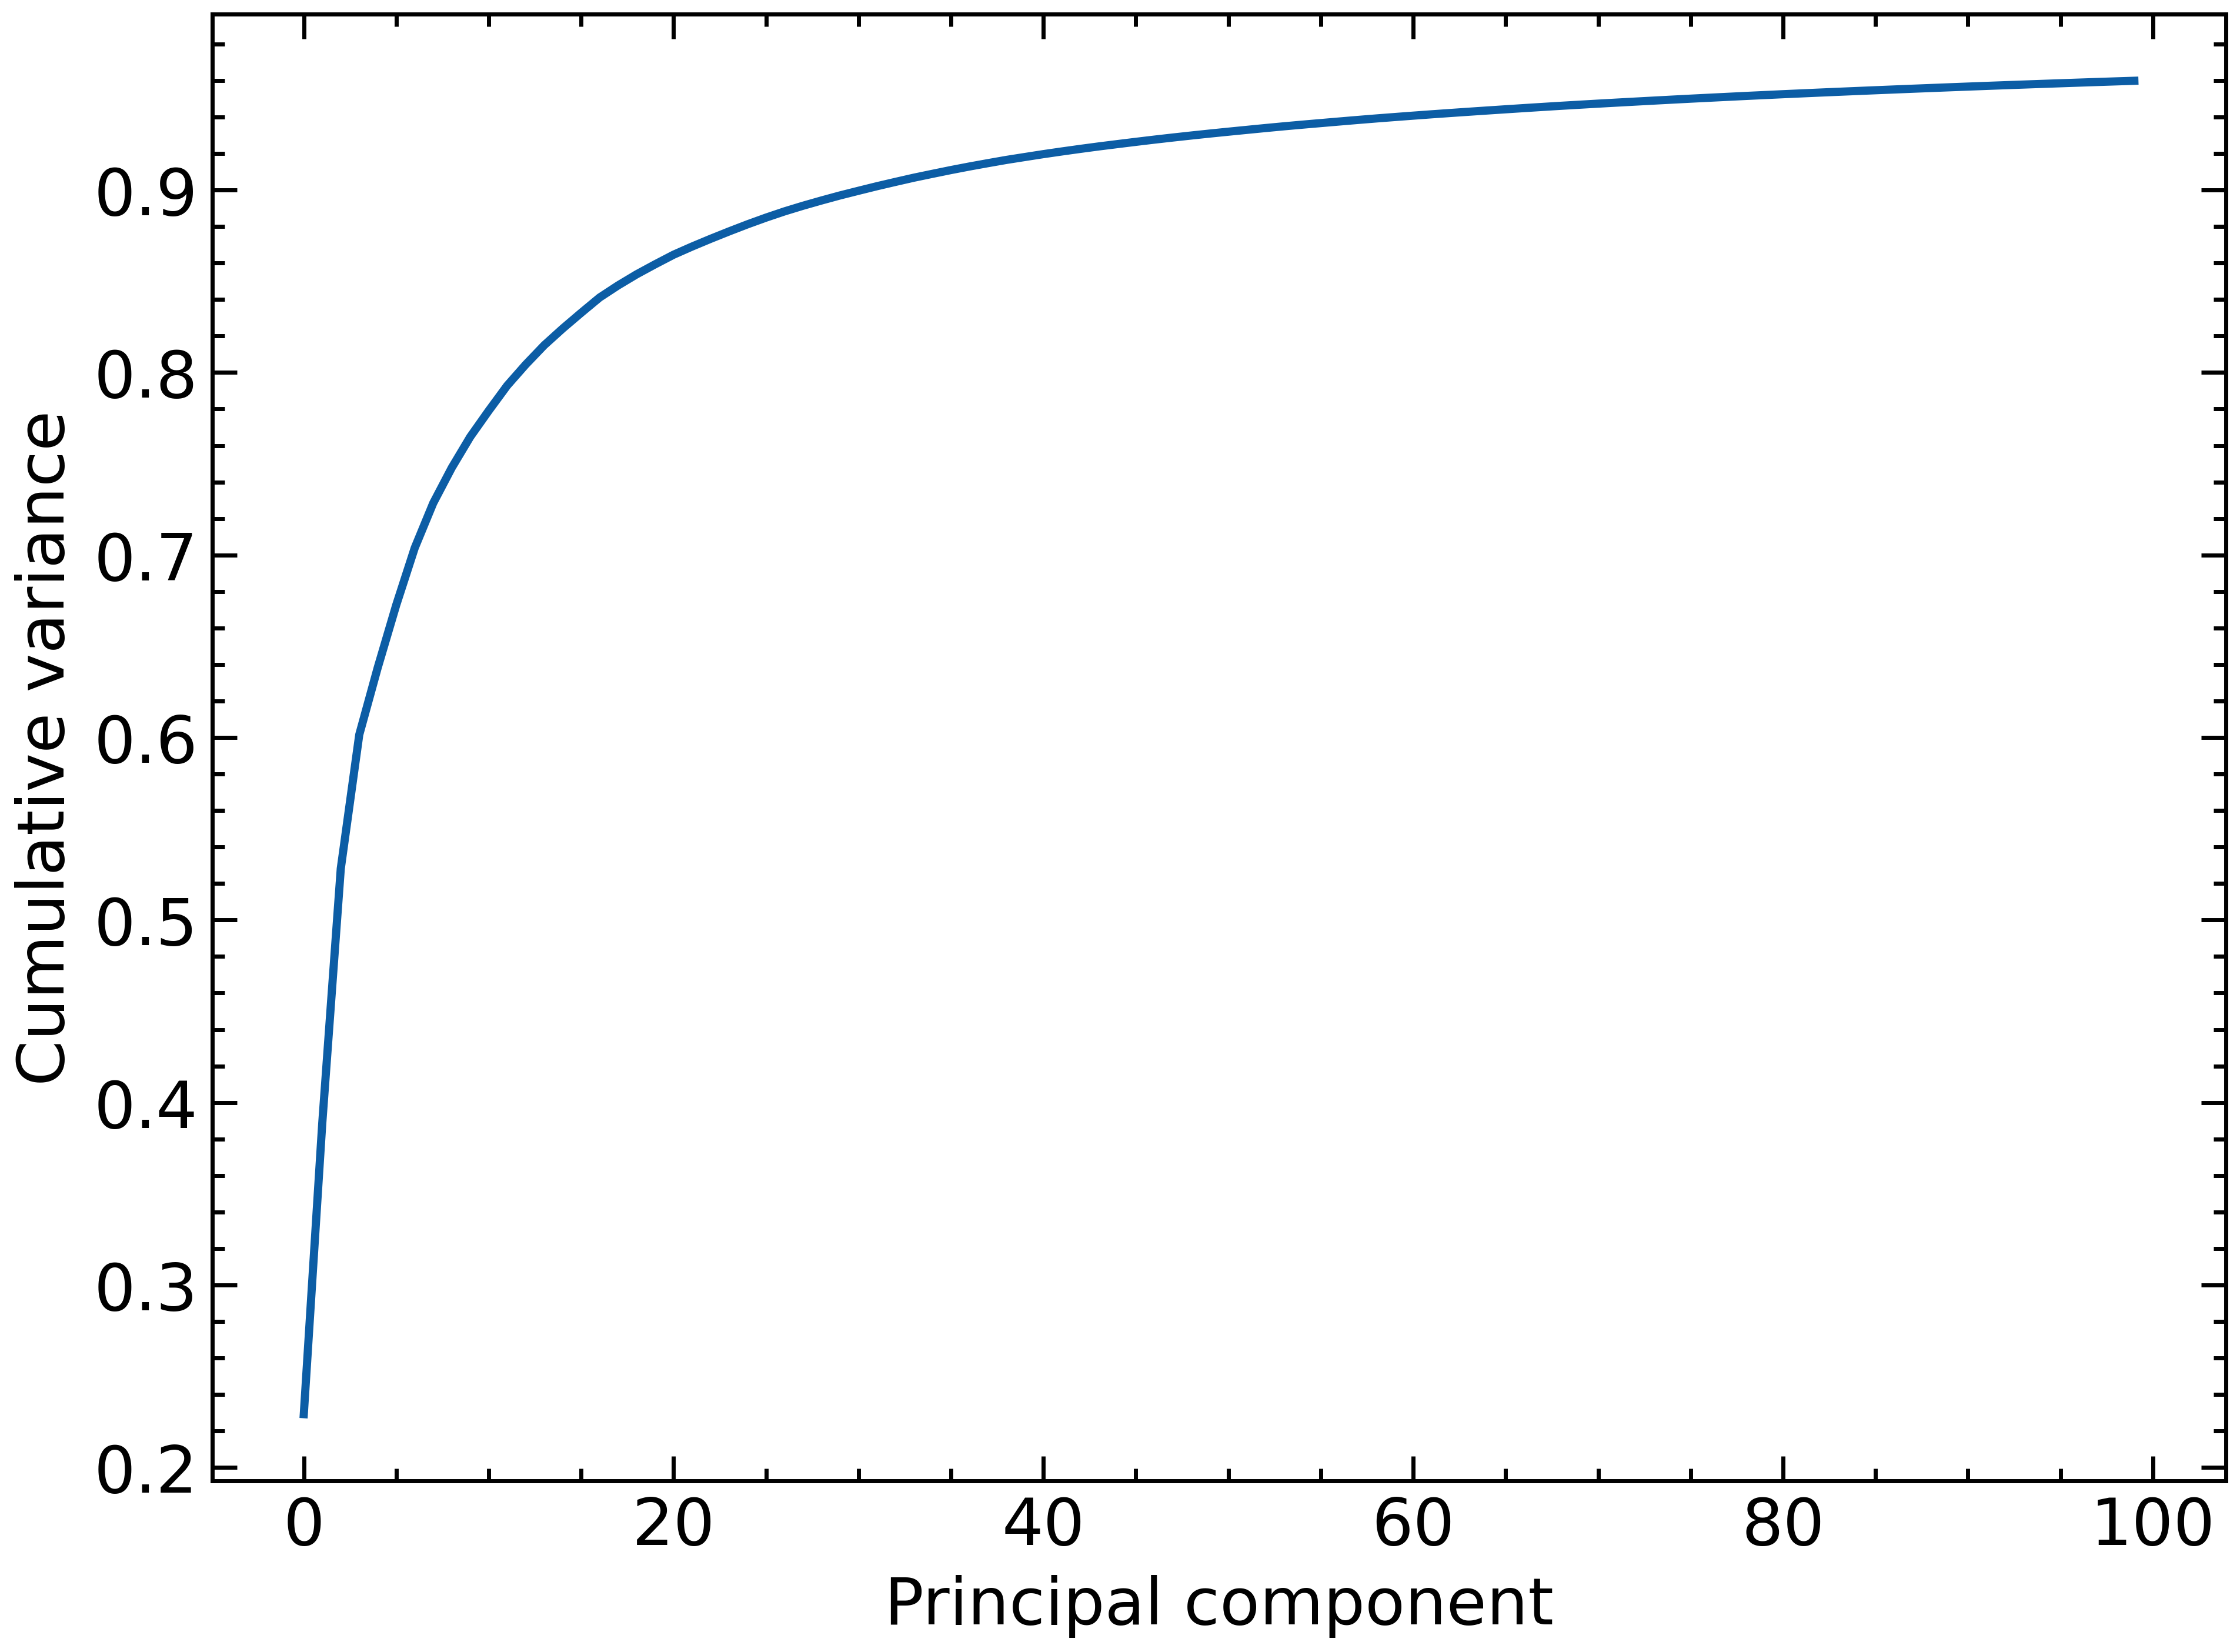

In [12]:
print(pc.p_components.shape)
plt.plot(pc.cumulated_variance[:100])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance')
plt.show()

**Notabene:** The cumulative variances are kinda cruddy here. You need to go to more than $10$ dimensions to get around $90\%$ of the correlations. However, that's too many dimensions, and we'll have to stick to $2$, as unrepresentative as this will be.

In [15]:
import pandas as pd
pca_components = 2
transformed = pc.transform(selection, n_components=pca_components)
df = pd.DataFrame(transformed, columns=['PC{}'.format(i+1) for i in range(pca_components)])
df['Time (ps)'] = df.index * mmp9_sb3ct_02.trajectory.dt
df.head()


PC1         PC2  Time (ps)
0   8.676474  118.023003        0.0
1  26.906163  116.822803       10.0
2  19.939758  121.498234       20.0
3  29.641889  118.845337       30.0
4  19.559133  118.861711       40.0

This $PC1$ vs $PC2$ data is now seen in the $xy$ plane. The data is binned into a $2D$ histogram and filtered by a Gaussian for smoothening, yielding the dimensionless density of points $\rho$. The histogram is normalized so that the maximum value is unity.

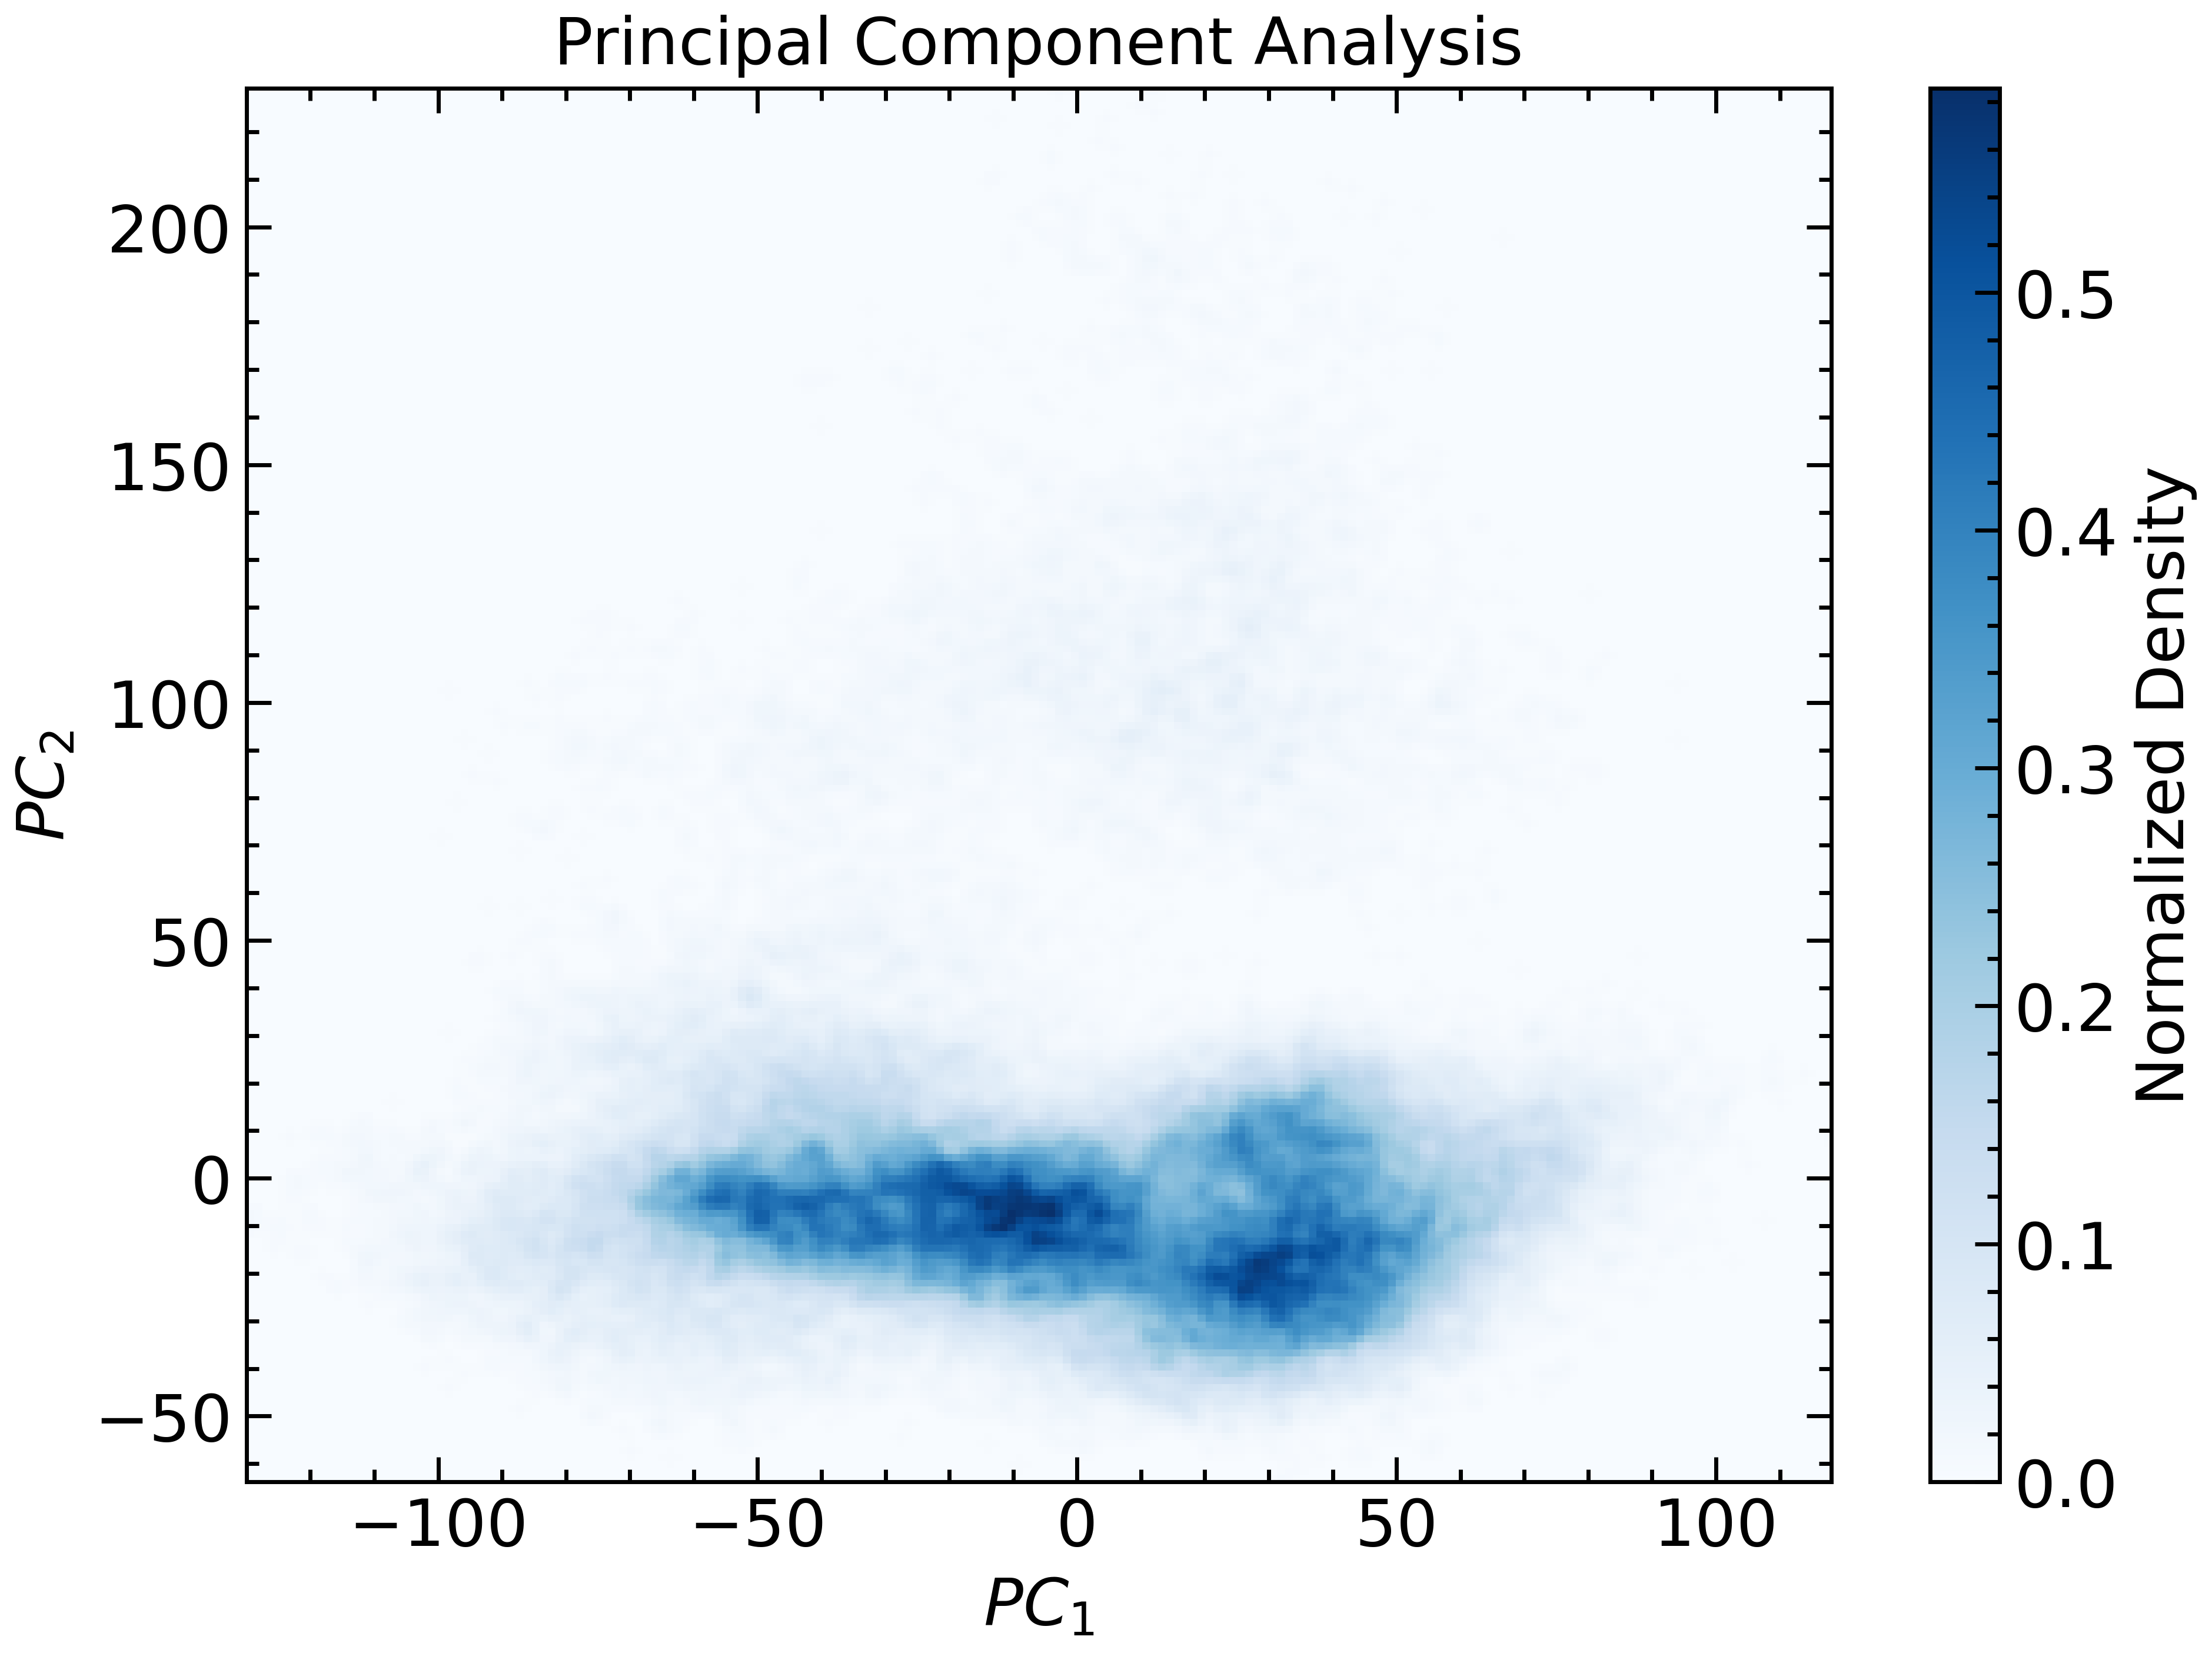

In [32]:
from scipy.ndimage import gaussian_filter

hist, xedges, yedges = np.histogram2d(df['PC1'], df['PC2'], bins=200)
hist = hist / hist.max()

hist = gaussian_filter(hist, sigma=1.0)

plt.imshow(hist.T, origin='lower', cmap='Blues', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
plt.colorbar(label='Normalized Density')
plt.xlabel(r'$PC_1$')
plt.ylabel('$PC_2$')
plt.title('Principal Component Analysis')
plt.show()

Now, free energy landscape is computed as $\Delta G = -k_BT\ln{\rho}$, with $k_BT = 0.592\; kcal/mol$. 
For this, I adapted [this method](https://md-davis.readthedocs.io/en/latest/guides/free_energy_landscapes.html). I believe this is what they call "Boltzmann Inversion".

The contours on the $xy$ plane are those of the density histogram from above.

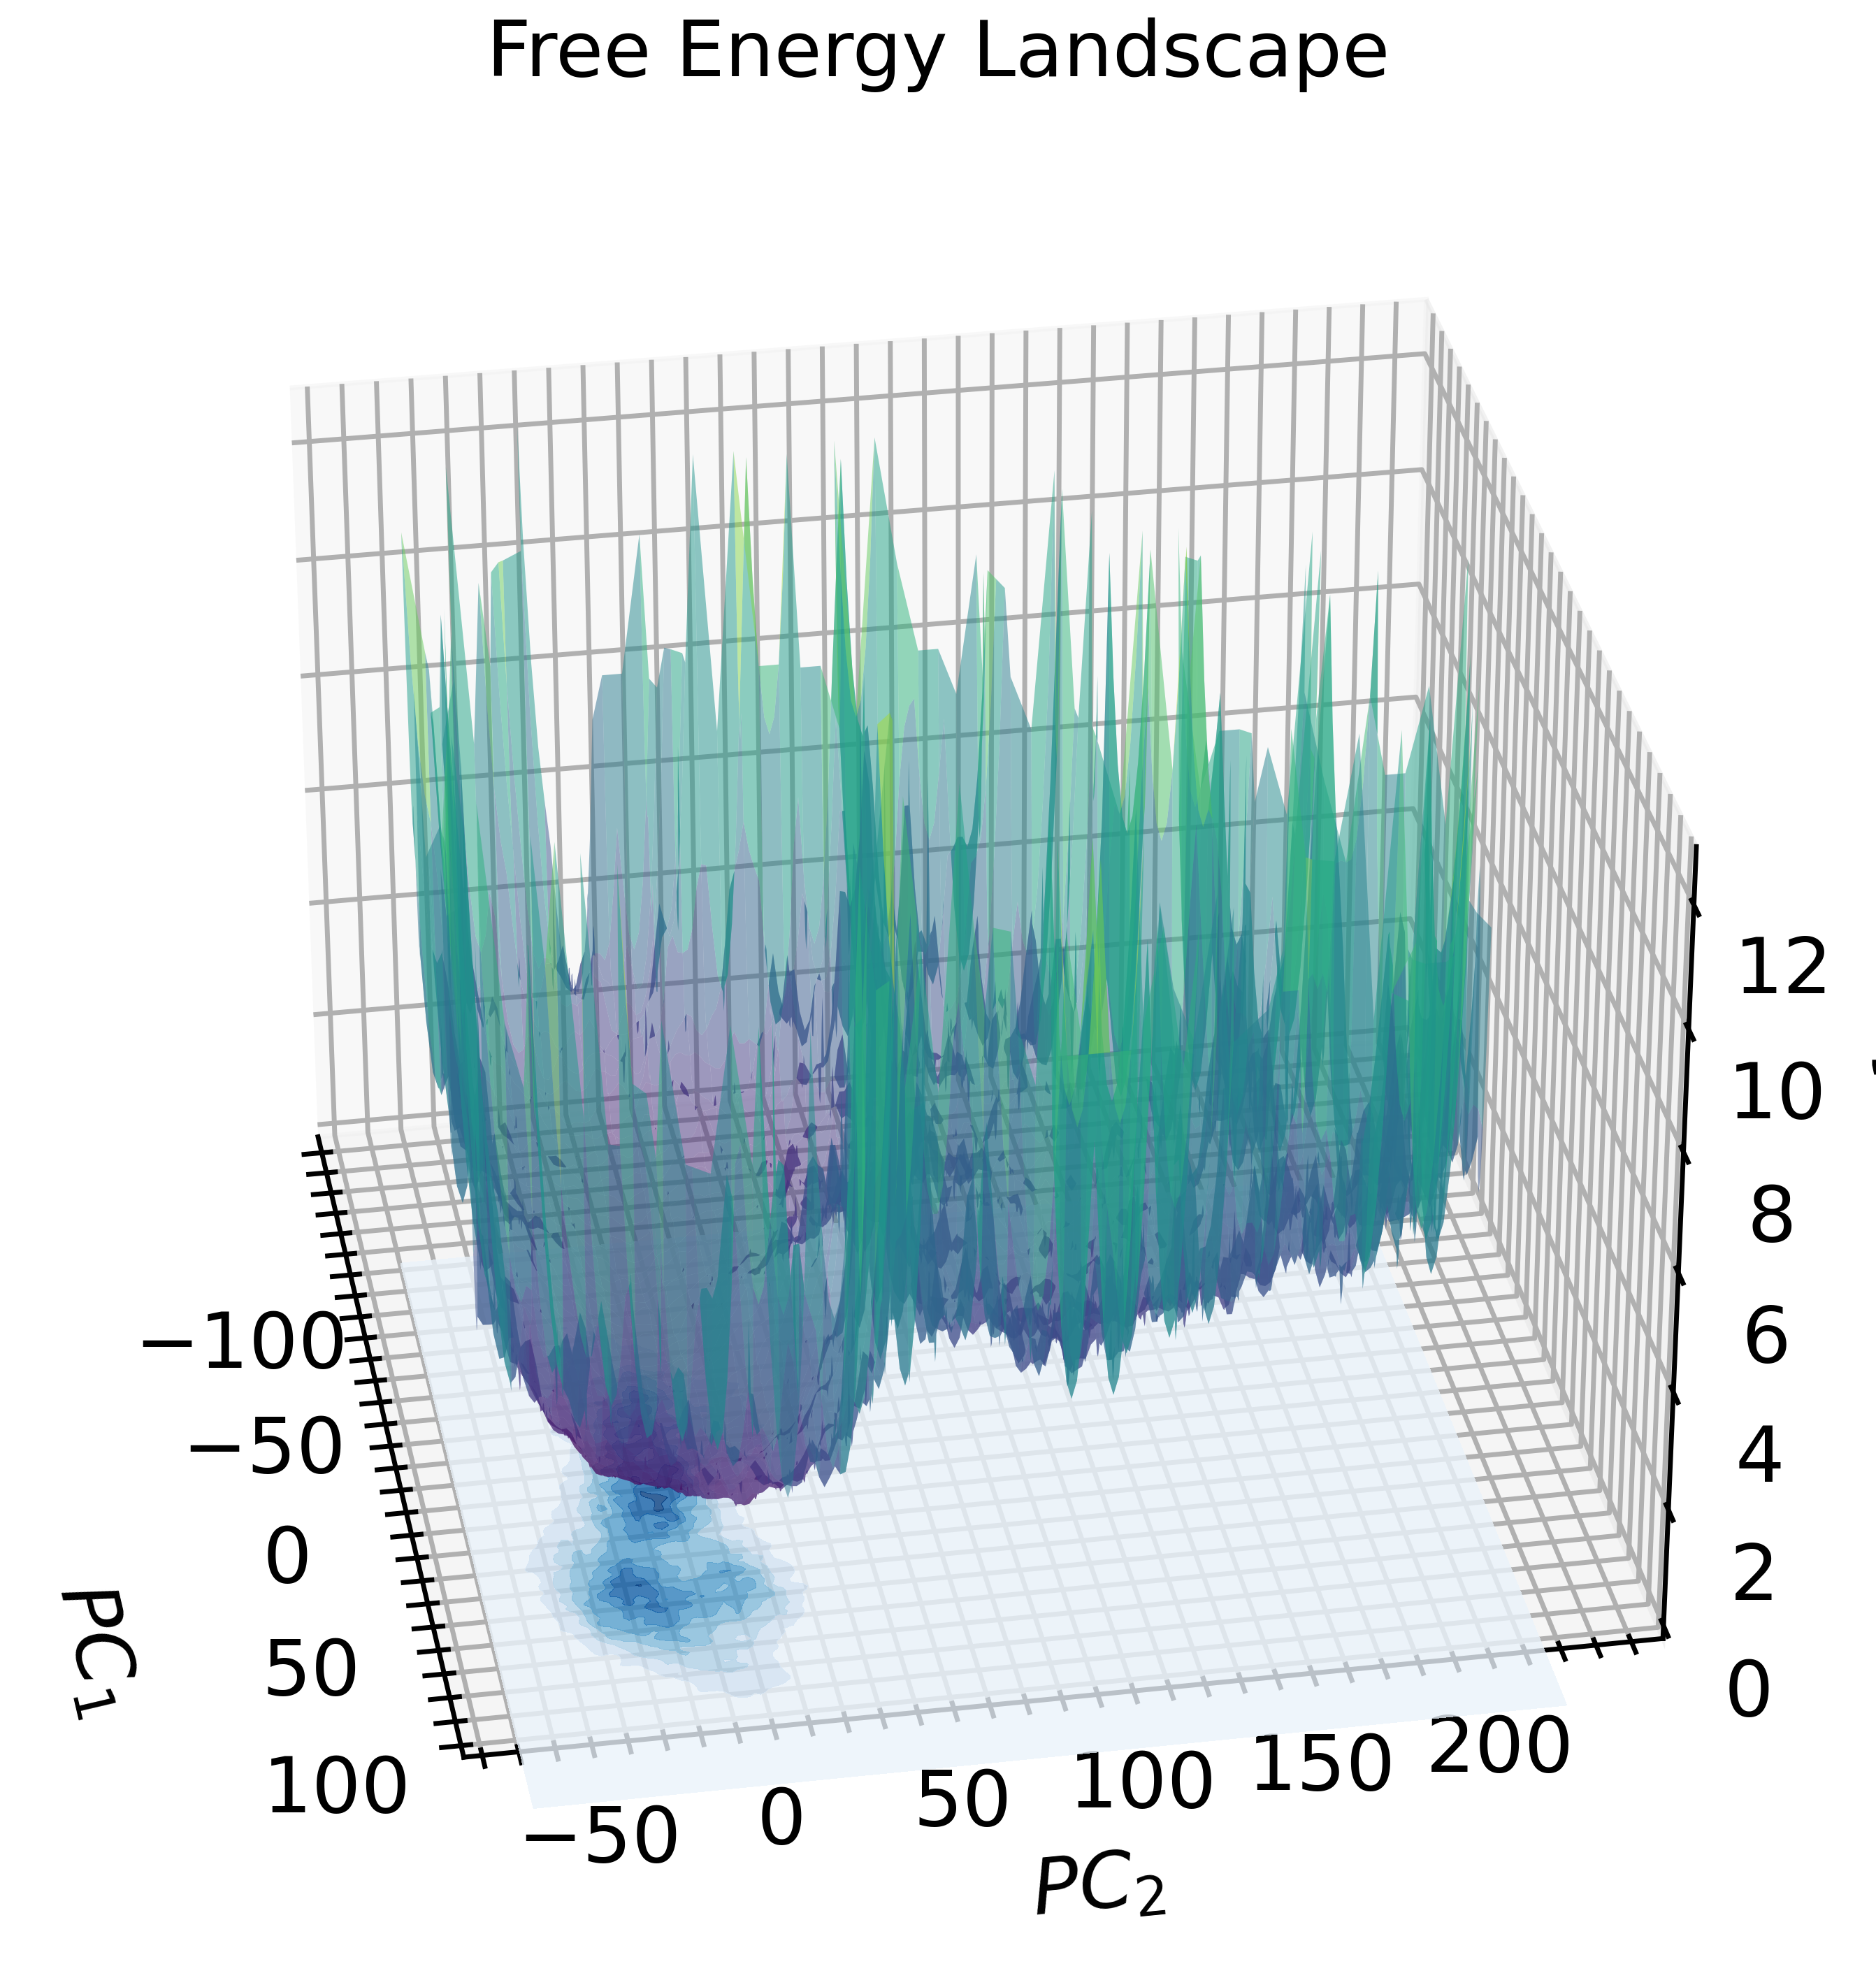

In [42]:
from mpl_toolkits.mplot3d import Axes3D
k_BT_kcalpermol = 0.592
free_energy = -k_BT_kcalpermol * np.log(hist)
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
Z = free_energy.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel(r'$\Delta G\; \left(kcal \cdot mol^{-1}\right)$', rotation=90, labelpad=10)
ax.set_xlabel(r'$PC_1$', labelpad=30)
ax.xaxis.set_tick_params(pad=10)
ax.set_ylabel(r'$PC_2$', labelpad=5)
ax.yaxis.set_tick_params(pad=0)
plt.title('Free Energy Landscape')
ax.contourf(X, Y, hist.T, zdir='z', offset=-2, cmap='Blues', alpha=0.8)

ax.view_init(elev=30, azim=-10)
plt.show()

### PCA via GROMACS tools

Firt, create an index for backbone, ligand and zinc

`gmx make_ndx -f md500.gro -o md500_pca.ndx` Choose backbone OR LIG OR ZN2

Then, we need to dump the first frame of MD simulation as pdb file (unless that has already been done).

`gmx trjconv -s md.tpr -f md500_compact_compact.xtc -o start.pdb -dump 0`

Selections should be the index just created.

Then, generating the eigenvectors

`gmx covar -s start.pdb -f md_center.xtc -o eigenvalues.xvg -v eigenvectors.trr -xpma covapic.xpm -n md500_pca.ndx`
Selections should be the index just created.

Followed by `gmx anaeig` to generate pc1 and pc2 files

`gmx anaeig -f md500_compact_compact.xtc -s start.pdb -v eigenvectors.trr -last 1 -proj pc1.xvg -n md500_pca.ndx`

`gmx anaeig -f md500_compact_compact.xtc -s start.pdb -v eigenvectors.trr -first 2 -last 2 -proj pc2.xvg -n md500_pca.ndx`

Use these two xvg files (pc1.xvg and pc2.xvg) to generate the following plots.

In [ ]:
import numpy as np

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for RMSD and radius of gyration XVG files
pc1_file = '/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run2/pc1.xvg'
pc2_file = '/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run2/pc2.xvg'

# Read data from XVG files with skip headers
t1, pc1_data = read_xvg(pc1_file, skip_header=24)  # Adjust skip_header based on your file format
t2, pc2_data = read_xvg(pc2_file, skip_header=24)  # Adjust skip_header based on your file format

For PCA with respect to energy, first

`paste pc1.xvg pc2.xvg | awk '{print $1, $2, $4}' > PC1PC2.xvg`

Then, use this PC1PC2.xvg file to generate an xpm file

`gmx sham -f PC1PC2.xvg -ls FES.xpm`

Then use the following `xpm2txt.py` script to convert the .xpm file into .dat file:


In [ ]:
#!/usr/bin/env python3

import sys

"""
Utility tool to convert xpm files generated by GROMACS to a 3-column text file.
"""

USAGE = "USAGE: xpm2txt.py -f <input xpm file> -o <output txt file> [-s]\n"
USAGE += "Options:\n"
USAGE += "\t-s\t(int)\tSorts the output by a given column"
USAGE += "\n"  # always keep this line

# Parse arguments
read_input, read_output, sort = False, False, False
xpm_file, out_file, column_sort = None, None, None
for arg in sys.argv[1:]:
    if read_input:
        read_input = False
        xpm_file = arg
    elif read_output:
        read_output = False
        out_file = arg
    elif sort:
        sort = False
        column_sort = int(arg)
    if arg.startswith("-"):
        if arg == "-f":
            read_input = True
            continue
        elif arg == "-o":
            read_output = True
            continue
        elif arg == "-s":
            sort = True
        else:
            print(USAGE)
            sys.stderr.write('ERROR: Option not recognized: %s\n' % arg)
            sys.exit(1)

if not xpm_file:
    print(USAGE)
    sys.stderr.write('ERROR: You forgot to provide an input file.\n')
    sys.exit(1)
if not out_file:
    out_file = "out.txt"

# Parse XPM file
with open(xpm_file) as xpm_handle:
    xpm_data = []
    x_axis, y_axis = [], []
    letter_to_value = {}
    for line in xpm_handle:
        if line.startswith("/* x-axis"):
            x_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith("/* y-axis"):
            y_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith('"') and x_axis and y_axis:  # Read data
            xpm_data.insert(0, line.strip().strip(',')[1:-1])

        if line.startswith('"') and len(line.split()) > 4:
            letter = line.split()[0][1:]
            value = float(line.split()[-2][1:-1])
            letter_to_value[letter] = value

# Match x/y/data
txt_values = []
for y_index, data_value in enumerate(xpm_data):
    y_value = y_axis[y_index]
    for x_index, x_value in enumerate(x_axis):
        txt_values.append([x_value, y_value, letter_to_value[data_value[x_index]]])

# Apply sorting if requested
if column_sort:
    try:
        txt_values.sort(key=lambda x: x[column_sort - 1])
    except IndexError:
        print(USAGE)
        sys.stderr.write('ERROR: Column not found (%s)\n' % (column_sort))
        sys.exit(1)

# Print to file
with open(out_file, 'w') as out_handle:
    for x, y, z in txt_values:
        out_handle.write("%3.5f\t%3.5f\t%3.5f\n" % (x, y, z))

Use this above-mentioned script as

`./xpm2txt.py -f FES.xpm -o FEL.dat`

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Read input data from a file
input_file = '/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run2/FEL.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC1 = data[:, 0]
PC2 = data[:, 1]
free_energy = data[:, 2]


# Function to read XVG file and extract data
def read_xvg(file_path):
    data = np.genfromtxt(file_path, skip_header=18)  # Adjust skip_header based on your XVG file format
    time_points = data[:, 0]
    rmsd_values = data[:, 1]
    return time_points, rmsd_values

# Replace these placeholders with your actual file paths
D1_path = '/home/daneel/workspace/MMP9_SB3CT_20241209/1l6j_run2/eigenvalues.xvg'

# Read data from XVG files
time_D1, D1_data = read_xvg(D1_path)


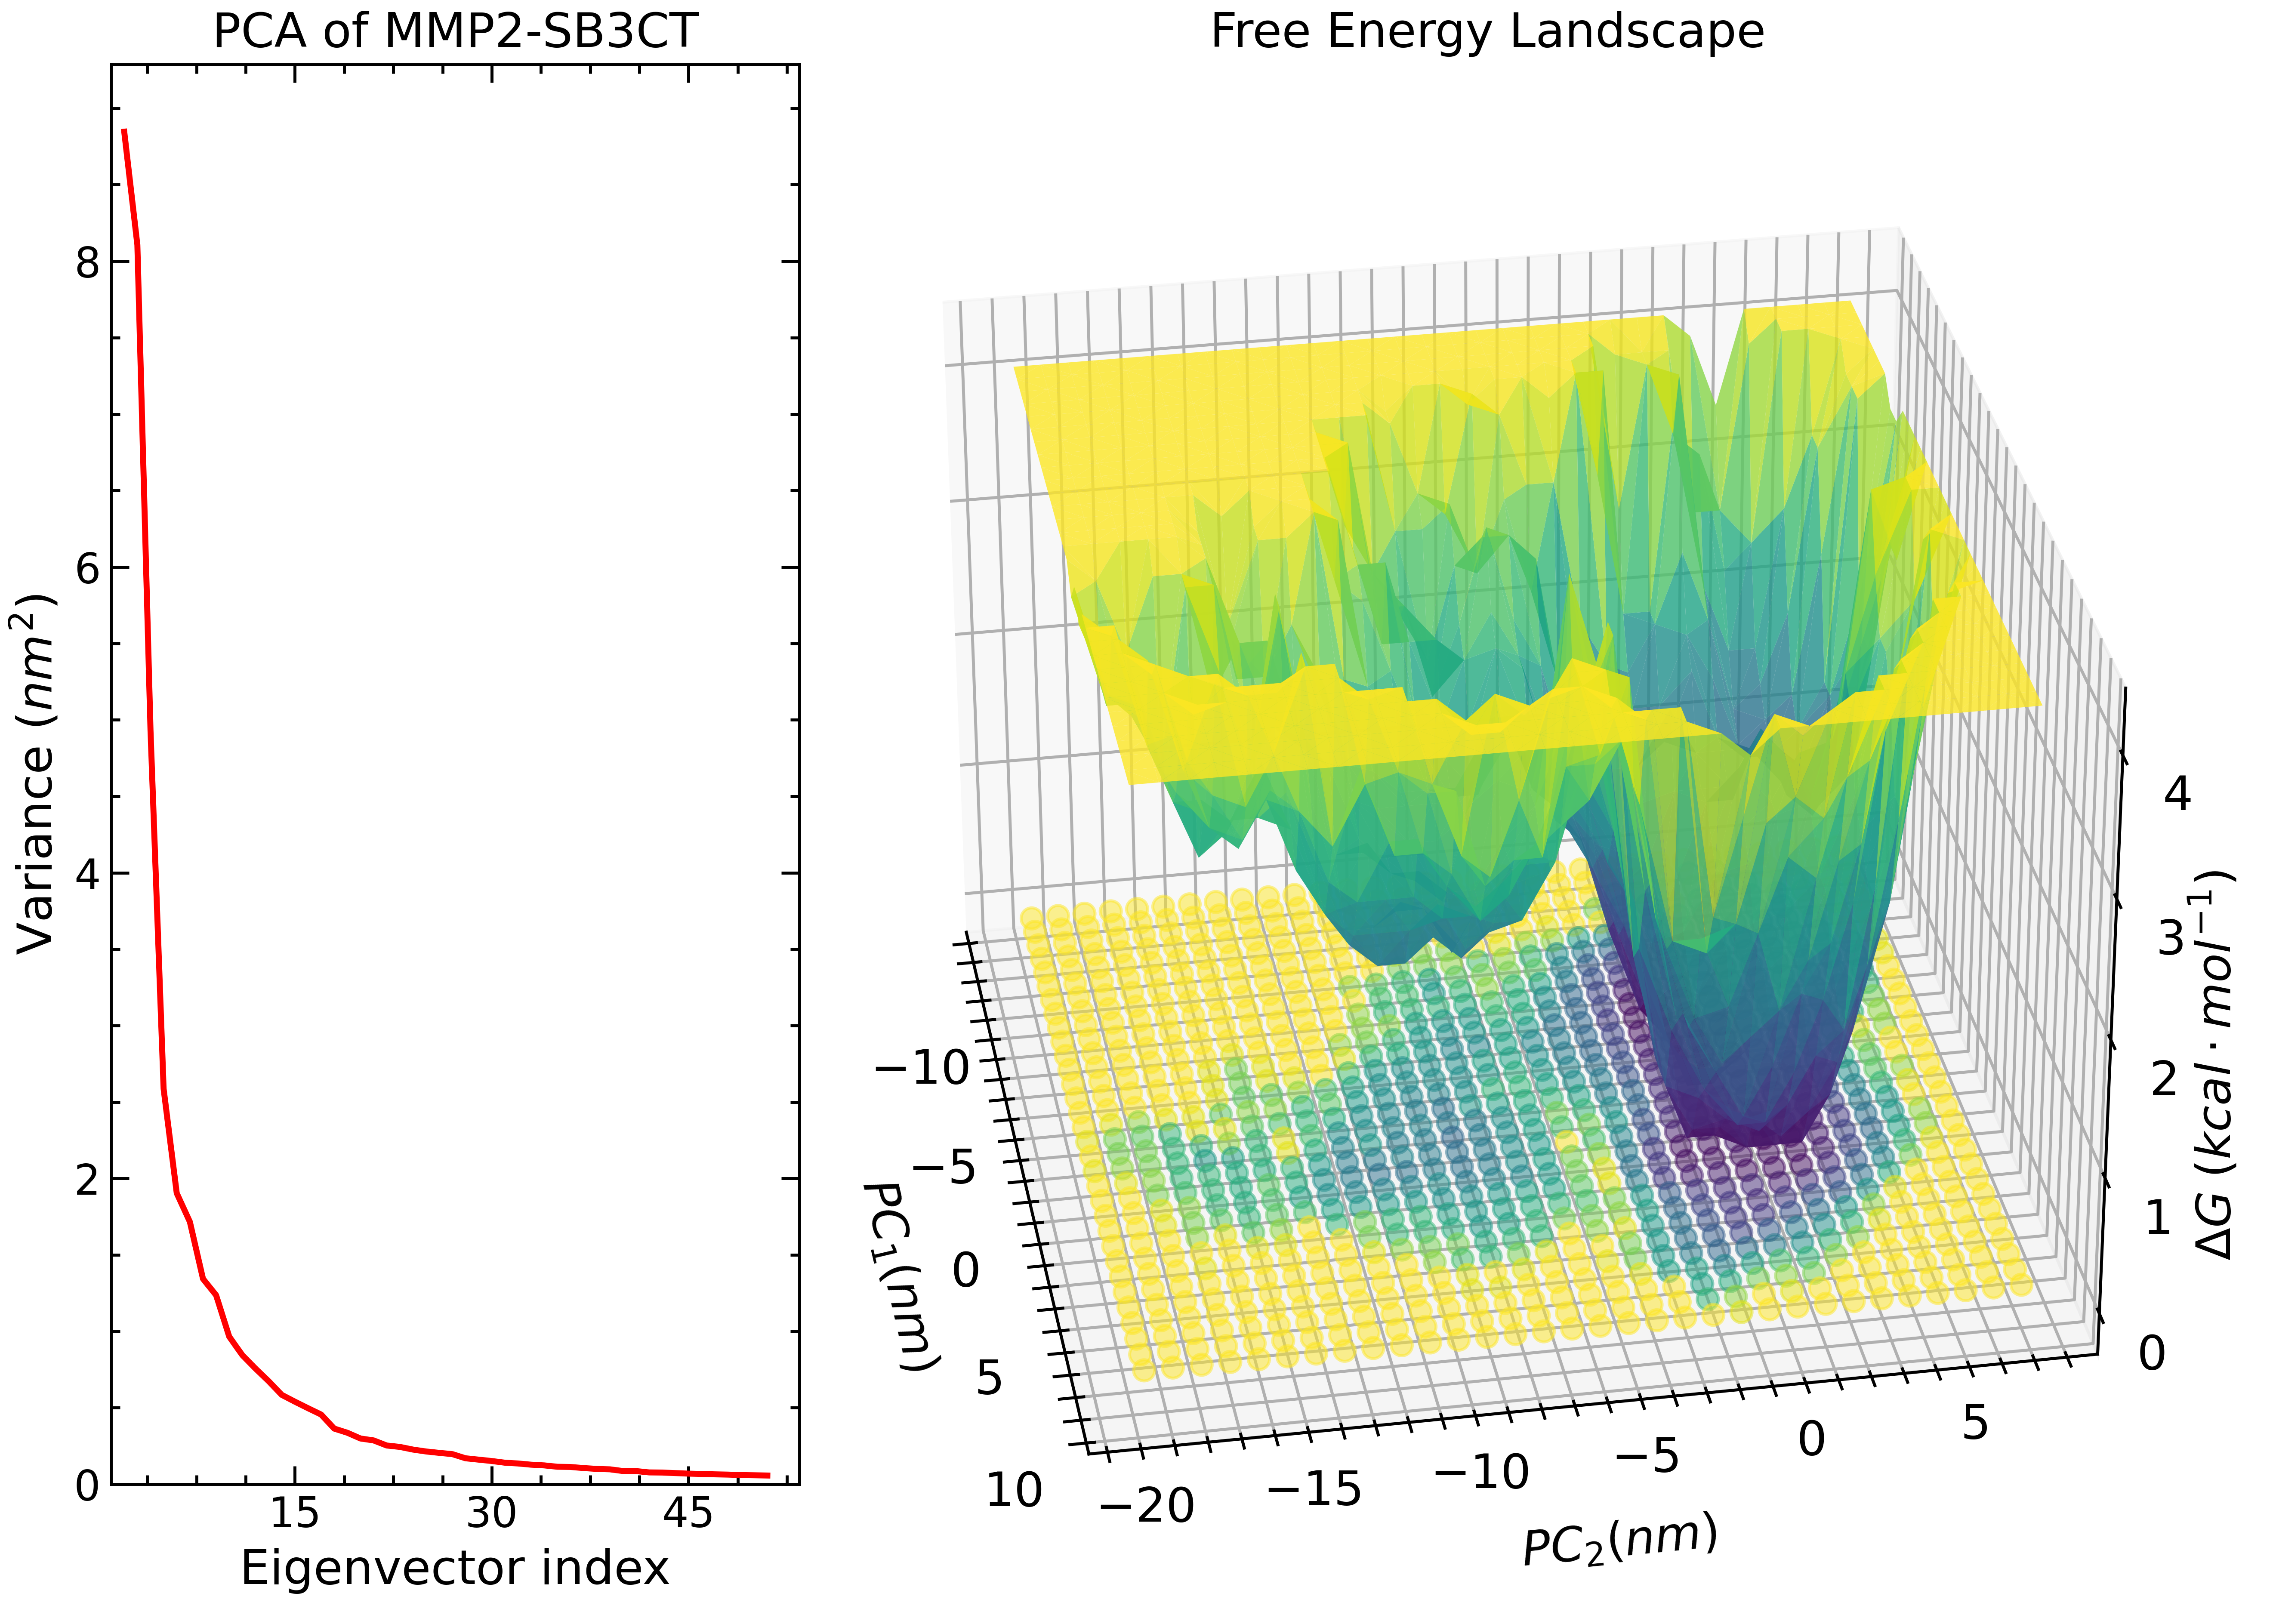

In [108]:
from mpl_toolkits.mplot3d import Axes3D
import scienceplots
plt.style.use(['science','notebook'])

fig = plt.figure()
ax = fig.add_subplot(211, projection='3d')
ax.plot_trisurf(PC1, PC2, free_energy/4.184, cmap='viridis', alpha=0.8)

ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel(r'$\Delta G\; \left(kcal \cdot mol^{-1}\right)$', rotation=90, labelpad=1)
ax.set_xlabel(r'$PC_1\left(nm\right)$', labelpad=15)
ax.xaxis.set_tick_params(pad=10)
ax.set_ylabel(r'$PC_2\left(nm\right)$', labelpad=10)
ax.yaxis.set_tick_params(pad=0)
ax.view_init(elev=30, azim=-10)
ax.set_title('Free Energy Landscape');
ax.scatter(PC1, PC2, c=free_energy/4.184, cmap='viridis', s=50, alpha=0.5)
# Adjust the size of the 3D plot
ax.set_position([0.1, 0.1, 1.6, 1.2])  # [left, bottom, width, height]

# Add the second subplot
ax2 = fig.add_subplot(212)
ax2.plot(time_D1[0:50], D1_data[0:50], color='red')
ax2.set_xlim(1, )
ax2.set_ylim(0, )
ax2.set_xlabel('Eigenvector index', fontsize=16)
ax2.set_ylabel(r'Variance $\left(nm^2\right)$', fontsize=16)
ax2.xaxis.set_major_locator(plt.MaxNLocator(4))
ax2.yaxis.set_major_locator(plt.MaxNLocator(5))
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_title('PCA of MMP2-SB3CT')
ax2.set_position([0.1, 0.2, 0.4, 1.1])  # [left, bottom, width, height]

### PCA Conclusion

The `gromacs` way is quantitatively better, although both `gromacs` and `MDAnalysis` yield similar qualitative landscapes. I'm inclined to prefer the `gromacs` data as there are clearly fewer truncation errors in while selecting the first two principal axes compared to `MDAnalysis`.